<a href="https://colab.research.google.com/github/onurburakozdemir/FIZ437E/blob/main/HW5/HW5_Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## İmportlar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

dataset_path = 'MIDI'

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Dataset Yükleme

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/MIDI')
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 2194


## MIDI işleme

In [ ]:
sample_file = filenames[1]
print(sample_file)

/content/drive/MyDrive/MIDI/isfahan--sazsemaisi--aksaksemai----tanburi_cemil_bey.mid


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
 
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

### Örnek parça

In [ ]:
display_audio(pm)

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## MIDI'den notaya

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=71, note_name=B4, duration=0.3239
1: pitch=73, note_name=C#5, duration=0.1080
2: pitch=71, note_name=B4, duration=0.2159
3: pitch=72, note_name=C5, duration=0.2159
4: pitch=74, note_name=D5, duration=0.4318
5: pitch=76, note_name=E5, duration=0.2159
6: pitch=77, note_name=F5, duration=0.2159
7: pitch=76, note_name=E5, duration=0.4318
8: pitch=74, note_name=D5, duration=0.2159
9: pitch=76, note_name=E5, duration=0.2159


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,71,0.000000,0.323864,0.000000,0.323864
1,73,0.340909,0.448864,0.340909,0.107955
2,71,0.454545,0.670455,0.113636,0.215909
3,72,0.681818,0.897727,0.227273,0.215909
4,74,0.909091,1.340909,0.227273,0.431818


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B4', 'C#5', 'B4', 'C5', 'D5', 'E5', 'F5', 'E5', 'D5', 'E5'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

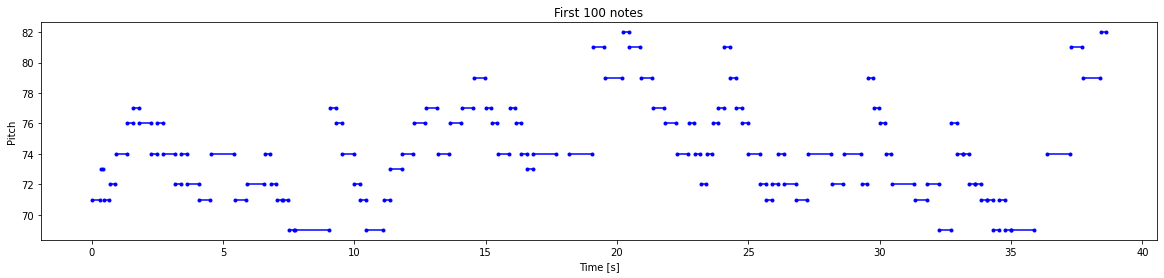

In [ ]:
plot_piano_roll(raw_notes, count=100)

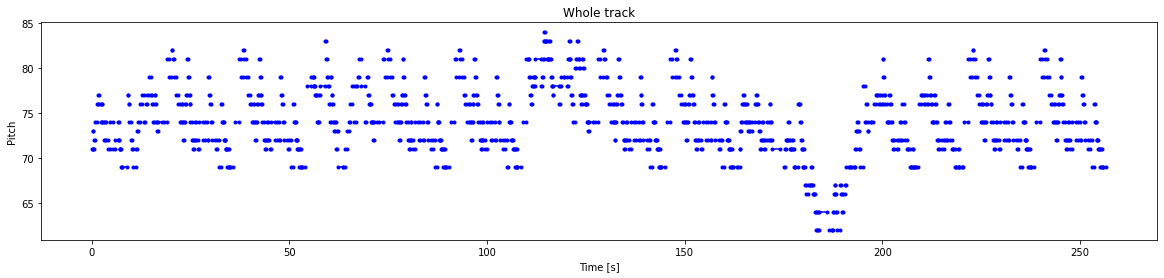

In [ ]:
plot_piano_roll(raw_notes)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

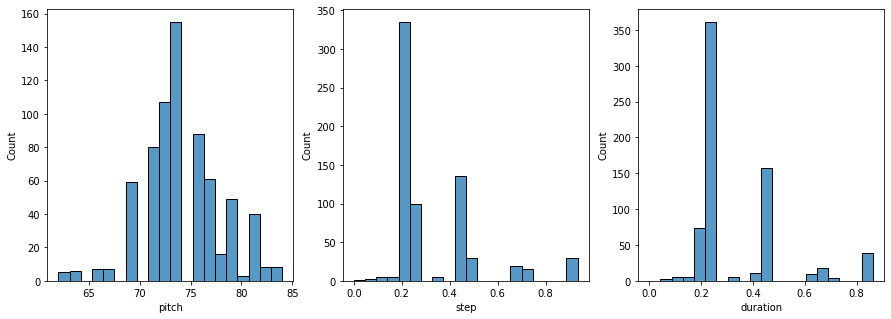

In [ ]:
plot_distributions(raw_notes)

## Notadan MIDI'ye



In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name="String Ensemble 2")

In [ ]:
display_audio(example_pm)

## Train Dataset


In [ ]:
num_files = 130
all_notes = []
for f in filenames[:num_files]:
    try:
      notes = midi_to_notes(f)
      all_notes.append(notes)
    except:
      True
all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 48084


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (50, 3)
sequence elements (first 10): tf.Tensor(
[[0.5234375  0.         0.475     ]
 [0.5390625  0.5        0.475     ]
 [0.5390625  0.5        0.475     ]
 [0.5390625  0.5        0.475     ]
 [0.5390625  0.5        0.475     ]
 [0.5390625  0.5        0.475     ]
 [0.5390625  0.5        0.49583333]
 [0.5234375  0.5        0.475     ]
 [0.5703125  0.5        0.49583333]
 [0.578125   0.5        0.49583333]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=69.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.4750000000000014>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 50, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Model oluşturma ve eğitme

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 lstm_5 (LSTM)                  (None, 128)          67584       ['input_6[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_5[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_5[0][0]']                 
                                                                                            

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

750/750 [==============================] - 43s 45ms/step - loss: 5.2829 - duration_loss: 0.2335 - pitch_loss: 4.8350 - step_loss: 0.2144


{'duration_loss': 0.23348335921764374,
 'loss': 5.28290319442749,
 'pitch_loss': 4.834985256195068,
 'step_loss': 0.21443693339824677}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

750/750 [==============================] - 36s 46ms/step - loss: 0.6897 - duration_loss: 0.2335 - pitch_loss: 4.8350 - step_loss: 0.2144


{'duration_loss': 0.23348335921764374,
 'loss': 0.689669132232666,
 'pitch_loss': 4.834985256195068,
 'step_loss': 0.21443693339824677}

Train the model.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
750/750 [==============================] - 61s 81ms/step - loss: 0.2459 - duration_loss: 0.0973 - pitch_loss: 2.6982 - step_loss: 0.0137
Epoch 2/50
750/750 [==============================] - 61s 81ms/step - loss: 0.2347 - duration_loss: 0.0955 - pitch_loss: 2.5169 - step_loss: 0.0133
Epoch 3/50
750/750 [==============================] - 63s 84ms/step - loss: 0.2208 - duration_loss: 0.0944 - pitch_loss: 2.2666 - step_loss: 0.0131
Epoch 4/50
750/750 [==============================] - 62s 83ms/step - loss: 0.2150 - duration_loss: 0.0936 - pitch_loss: 2.1638 - step_loss: 0.0132
Epoch 5/50
750/750 [==============================] - 61s 81ms/step - loss: 0.2114 - duration_loss: 0.0929 - pitch_loss: 2.1132 - step_loss: 0.0129
Epoch 6/50
750/750 [==============================] - 61s 81ms/step - loss: 0.2090 - duration_loss: 0.0922 - pitch_loss: 2.0805 - step_loss: 0.0129
Epoch 7/50
750/750 [==============================] - 61s 81ms/step - loss: 0.2070 - duration_loss: 0.0913 - pit

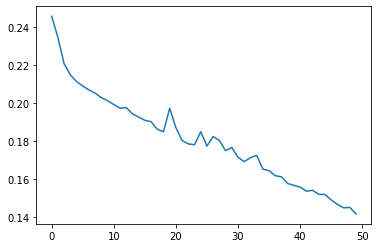

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Nota türetme


In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,81,0.648025,0.390076,0.648025,1.038101
1,86,0.077432,0.282491,0.725456,1.007948
2,86,0.080059,0.263222,0.805515,1.068737
3,86,0.081009,0.261862,0.886524,1.148387
4,86,0.081145,0.261681,0.967669,1.229350
5,86,0.081133,0.261575,1.048802,1.310377
6,86,0.081200,0.261739,1.130002,1.391741
7,84,0.081178,0.261681,1.211180,1.472862
8,86,0.081134,0.261573,1.292314,1.553887
9,86,0.081147,0.261599,1.373461,1.635060


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name="String Ensemble 2")
display_audio(out_pm)

#### Müziği indirmek için:

In [ ]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

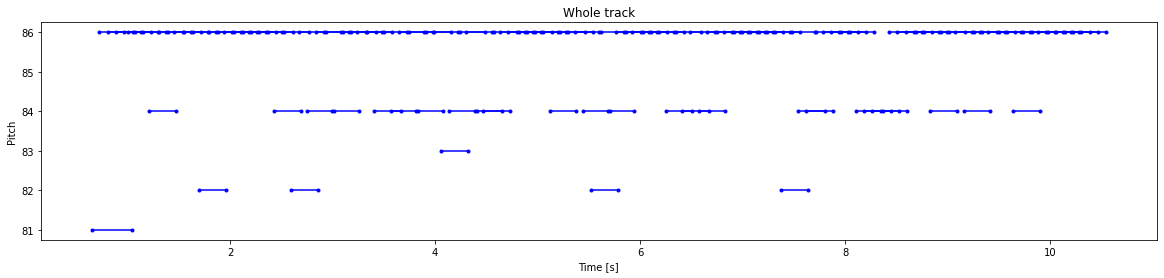

In [ ]:
plot_piano_roll(generated_notes)

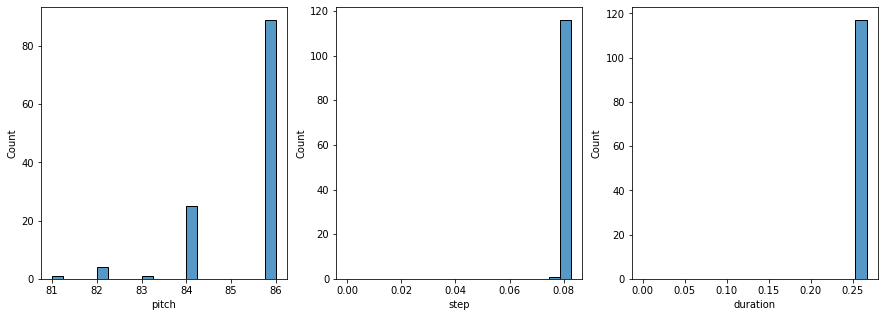

In [ ]:
plot_distributions(generated_notes)